In [75]:
from ema_workbench import load_results
from ema_workbench.analysis import prim

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [77]:
from plotting import save_fig

In [78]:
no_flood = False

nfl = ""
if no_flood:
    nfl = "no_flood/"

In [79]:
path = f'../results/{nfl}'
file_name = '2000_scen__AGGD_reps__0612__burned_in__with_rates__with_clusters__K6'
file_ext  = '.tar.gz'

### Set-up

In [80]:
results = load_results(path + file_name + file_ext)
experiments, outcomes = results

In [81]:
cluster_vars = [col for col in experiments if 'Cluster' in col and col.count('[') == 0] # Straight outcomes
cluster_vars.extend([col for col in experiments if col[:12] == 'Cluster (VAR']) # Variance outcomes
cluster_vars

['Cluster (Household Population)',
 'Cluster (Gini Coefficient)',
 'Cluster (Median Wage)',
 'Cluster (GDP)',
 'Cluster (Change in Household Population)',
 'Cluster (Change in GDP)',
 'Cluster (Change in Gini Coefficient)',
 'Cluster (Change in Median Wage)',
 'Cluster (VAR[Household Population])',
 'Cluster (VAR[Gini Coefficient])',
 'Cluster (VAR[Median Wage])',
 'Cluster (VAR[GDP])']

In [82]:
cluster_vars = ['Cluster (Gini Coefficient)']

In [83]:
for var in cluster_vars:
    experiments[var] = experiments[var].astype('int32')

In [84]:
cols_to_ignore = ['scenario', 'policy', 'model'] 
for col in experiments.columns: 
    if 'Cluster' in col:
        cols_to_ignore.append(col)

experiments_prim = experiments[[c for c in experiments.columns if c not in cols_to_ignore]]
experiments_prim.columns

Index(['debt_sales_ratio', 'wage_sensitivity_prod', 'init_markup',
       'capital_firm_cap_out_ratio', 'min_unempl_emigration',
       'migration_unempl_bounds_diff', 'deu_discount_factor', 'flood_timing'],
      dtype='object')

### PRIM for Rule Induction

In [85]:
density_threshold = 0.6

In [86]:
# Find a set of boxes for each
prim_boxes = {}
for var in cluster_vars:
    n_clusters = experiments[var].max() + 1

    prim_boxes[var] = {}
    for cluster in range(n_clusters):
        prim_alg = prim.Prim(experiments_prim,
                             experiments[var] == cluster,
                             threshold=density_threshold)
        prim_boxes[var][cluster] = prim_alg.find_box()

In [87]:
sns.set_style('whitegrid')

In [88]:
# Closer manual inspection:
## (b) (cluster 1): First candidate (density 60 cov 80) is 42, second (density 75 cov 70) is 48 :: SELECTED 48
## (d) (cluster 3): Best 2-res_dim is 51, 4-res_dim is 54 :: SELECTED 51

# clust = 1
# box = prim_boxes['Cluster (Household Population)'][clust] #[3]
# box.select(42)
# box.inspect(style='graph')
# save_fig(title=f'household population_ clust {clust}_ box 42_ rules',
#             dir=f'{nfl}rule_induction')

# box.select(48)
# box.inspect(style='graph')
# save_fig(title=f'household population_ clust {clust}_ box 48 rules',
#             dir=f'{nfl}rule_induction')

|||| Cluster (Gini Coefficient) CLUSTER 0 ||||


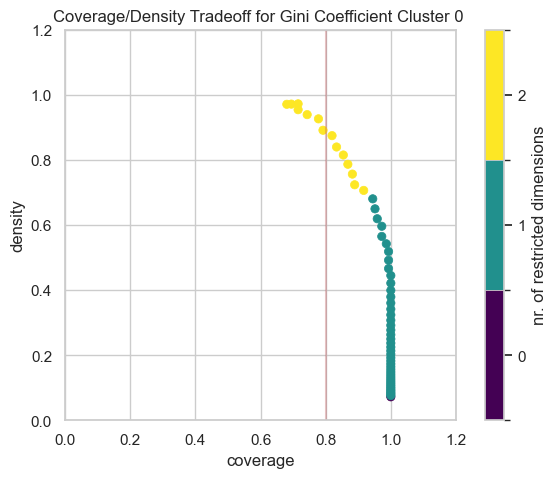

coverage      0.819444
density       0.874074
id           51.000000
k           118.000000
mass          0.067500
mean          0.874074
n           135.000000
res_dim       2.000000
Name: 51, dtype: float64

                 box 51                                    
                    min        max  qp value       qp value
init_markup    0.050066   0.081715       NaN  2.841013e-113
flood_timing  32.500000  80.000000  0.442733            NaN

|||| Cluster (Gini Coefficient) CLUSTER 1 ||||


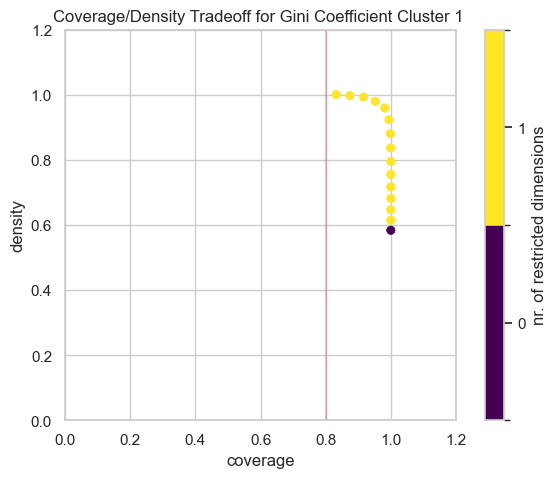

coverage      0.832048
density       1.000000
id           14.000000
k           971.000000
mass          0.485500
mean          1.000000
n           971.000000
res_dim       1.000000
Name: 14, dtype: float64

               box 14                                  
                  min       max       qp value qp value
init_markup  0.281598  0.499972  6.693842e-228      NaN

|||| Cluster (Gini Coefficient) CLUSTER 2 ||||


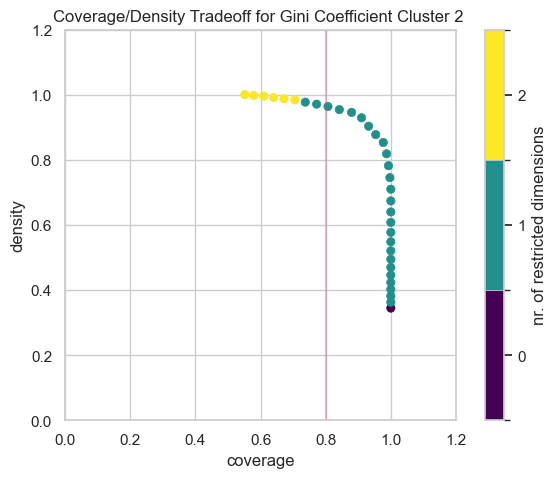

coverage      0.806967
density       0.963605
id           24.000000
k           556.000000
mass          0.288500
mean          0.963605
n           577.000000
res_dim       1.000000
Name: 24, dtype: float64

               box 24                                       
                  min       max      qp value       qp value
init_markup  0.095666  0.225552  1.980489e-31  1.172560e-222



In [89]:
lims = {}
for var in cluster_vars:
    lims[var] = {}
    for cluster, box in prim_boxes[var].items():
        print(f'|||| {var} CLUSTER {cluster} ||||')
        # Don't produce plot if no good results
        if len(box.peeling_trajectory) <= 1:
            print(f'Could not find suitable boxes for {var} Cluster {cluster} '
                  f'using density_threshold={density_threshold}')
            continue
        
        # Extract information from key name
        var_name = ''.join(var.split('(')[1:])[:-1]

        # Visualize coverage/density trade-off
        box.show_tradeoff()
        # plt.hlines(y=[0.7], xmin=0, xmax=1.2, colors='k', alpha=0.3)
        plt.vlines(x=[0.8], ymin=0, ymax=1.2, colors='r', alpha=0.3)
        
        plt.tight_layout()
        save_fig(title=f'{var_name}_ clust{cluster}_ cd tradeoff',
                 dir=f'{nfl}rule_induction')
        
        plt.title(f'Coverage/Density Tradeoff for {var_name} Cluster {cluster} ')
        plt.show()

        # Select specific box (densest box with coverage > 0.8)
        if var == 'Cluster (Household Population)' and cluster == 1:
            best_box = 48
        elif var == 'Cluster (Household Population)' and cluster == 3:
            best_box = 51
        else:
            acceptable_boxes = box.peeling_trajectory[(box.peeling_trajectory.coverage > 0.8)] # & 
                                                    #   (box.peeling_trajectory.density > 0.7)]
            if len(acceptable_boxes) < 1:
                print(f'Could not find box with coverage > 0.8 for {var_name} Cluster {cluster}')
                continue
            best_box = acceptable_boxes.index[-1]

        box.select(int(best_box))

        # Plot details of box
        box.inspect(style='table')
        # plt.title(f'Induced Rule for {var_name} Cluster {cluster} ')

        # plt.tight_layout()
        # save_fig(title=f'{var_name}_ clust{cluster}_ induced rule',
        #          dir=f'{nfl}rule_induction')
        
        # plt.show()

        # Save box limits for post-processing
        lims[var][cluster] = box.box_lims[int(best_box)]

In [58]:
independent_vars = list(experiments_prim.columns)

In [59]:
maxes = {var:experiments[var].max() for var in independent_vars} 
mins  = {var:experiments[var].min() for var in independent_vars}

In [60]:
# restricted_dims = {v:{c:[] for c in lims[v]} for v in cluster_vars} # If you care about dims per CLUSTER
restricted_dims = {v:[] for v in cluster_vars} # If you care about dims per VAR
for cluster_var in cluster_vars:
    for cluster, bounds in lims[cluster_var].items():
        for dim in independent_vars:
            if bounds[dim][0] != mins[dim] or bounds[dim][1] != maxes[dim]:
                # restricted_dims[cluster_var][cluster].append(dim) # Per cluster
                if dim not in restricted_dims[cluster_var]: # Per var
                    restricted_dims[cluster_var].append(dim)
restricted_dims

{'Cluster (GDP)': ['init_markup',
  'flood_timing',
  'capital_firm_cap_out_ratio']}

In [61]:
sns.set_style('white')
sns.set_theme(style='ticks', rc={'patch.edgecolor':'black', 'patch.linewidth':0.5})

In [62]:
def prim_box_plot(x, y, **kwargs):
    cluster_var = kwargs['cluster_var']
    cluster = kwargs['label']
    # Add transparency to color
    if 'alpha' in kwargs:
        alpha = kwargs['alpha']
    else:
        alpha = 0.5
    color = (
        kwargs['color'][0],
        kwargs['color'][1],
        kwargs['color'][2],
        alpha,
    )

    box_x_min = lims[cluster_var][cluster][x.name][0]
    box_x_max = lims[cluster_var][cluster][x.name][1]
    box_y_min = lims[cluster_var][cluster][y.name][0]
    box_y_max = lims[cluster_var][cluster][y.name][1]

    # Get reference to ax object
    ax = plt.gca()

    # Create rectangle for {cluster_var:cluster}'s box
    rect = plt.Rectangle(
        xy=(box_x_min, box_y_min),
        width=box_x_max-box_x_min,
        height=box_y_max-box_y_min,
        fc=color,
        ec='none'
    )
    ax.add_patch(rect)

    # Set subplot limits correctly
    x_range = maxes[x.name] - mins[x.name]
    y_range = maxes[y.name] - mins[y.name]

    x_buf = x_range * 0.05
    y_buf = y_range * 0.05

    ax.set_xlim((mins[x.name] - x_buf, maxes[x.name] + x_buf))
    ax.set_ylim((mins[y.name] - y_buf, maxes[y.name] + y_buf))
    # ax.set_xlim((mins[x.name], maxes[x.name]))
    # ax.set_ylim((mins[y.name], maxes[y.name]))

    if ax.get_subplotspec().is_first_col():
        ax.set_ylabel(y.name)
    if ax.get_subplotspec().is_first_row():
        ax.set_xlabel(x.name)
        
    return ax

In [63]:
cluster_palette = sns.color_palette("tab10", 10)

In [64]:
max(np.sort(experiments['Cluster (GDP)'].unique()))

3

In [65]:
# # HOUSEHOLD POPULATION
# cluster_names = [
#     'Fall-Growth',
#     'Fall-Level Off',
#     'Growth-Collapse',
#     'Steady Growth',
#     'Collapse-Recovery @ 30',
#     'Collapse-Recovery @ 50',
# ]

# # GDP
# cluster_names = [
#     'Post-Flood Stagnation/Collapse',
#     'Rapid Post-Flood Growth',
#     'Adequate Post-Flood Growth',
#     'Weak Economy',
# ]

# GINI
cluster_names = [
    'Low Initial-High Final',
	'Orange: High Initial-Low Final',
	'Green: Low Throughout',

]

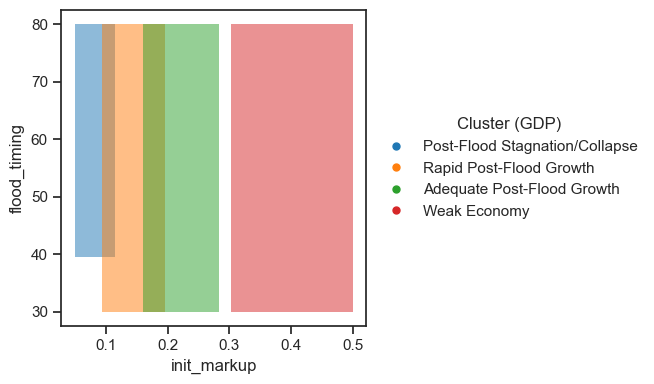

In [70]:
cluster_var = 'Cluster (GDP)'
clusters = np.sort(experiments[cluster_var].unique())
n_clusters = max(clusters) + 1

fig = plt.figure(figsize=(6.7,4))
for cluster in clusters:
   prim_box_plot(experiments['init_markup'],
               experiments['capital_firm_cap_out_ratio'],
               **{'cluster_var' : cluster_var,
                  'label' : cluster,
                  'color' : cluster_palette[cluster]})

# Create legend
handles = []
for color, cluster in zip(cluster_palette[:n_clusters], cluster_names):
   handles.append(mpl.lines.Line2D(
         [], [], color=color, marker='o',
         linestyle='None', markersize=5, label=cluster,
   ))

ax = plt.gca()
legend = ax.legend(
   title=cluster_var,
   handles=handles,
   bbox_to_anchor=(1,0.5),
   loc='center left',
   ncol=1
)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((1,1,1,0))
legend.get_frame().set_edgecolor((1,1,1,0))

plt.tight_layout()

var_name = ''.join(cluster_var.split('(')[1:])[:-1]
save_fig(title=f'{var_name}_ tipping point boxes', dir=f'{nfl}rule_induction')


In [67]:
# for cluster_var in cluster_vars:
#     try:
#         var_name = ''.join(cluster_var.split('(')[1:])[:-1]

#         g = sns.PairGrid(
#             experiments,
#             vars=restricted_dims[cluster_var],
#             hue=cluster_var,
#             palette='tab10',
#             corner=True,

#         )
#         g.map_diag(sns.kdeplot, multiple='fill')
#         g.map_offdiag(prim_box_plot, cluster_var=cluster_var)

#         plt.tight_layout()

#         # Create legend
#         handles = []
#         for color, cluster in zip(g.palette, g.hue_names):
#             handles.append(mpl.lines.Line2D(
#                 [], [], color=color, marker='o',
#                 linestyle='None', markersize=5, label=cluster,
#             ))

#         ax = plt.gca()
#         legend = ax.legend(
#             title=cluster_var,
#             handles=handles,
#             bbox_to_anchor=(1,0),
#             loc='center left',
#         )
#         legend.get_frame().set_alpha(None)
#         legend.get_frame().set_facecolor((1,1,1,0))
#         legend.get_frame().set_edgecolor((1,1,1,0))

#         # TODO: Figure out how to solve the legend problem with these figures.
        
#         # save_fig(title=f'{var_name}_ tipping point boxes', dir='')

#         # plt.suptitle(f'Influential model parameters on {var_name}',
#         #             y=1.04)
#         plt.show()
#     except:
#         print(f'Plotting failed for {cluster_var}. Probably couldn\'t find a box for some cluster.')
    

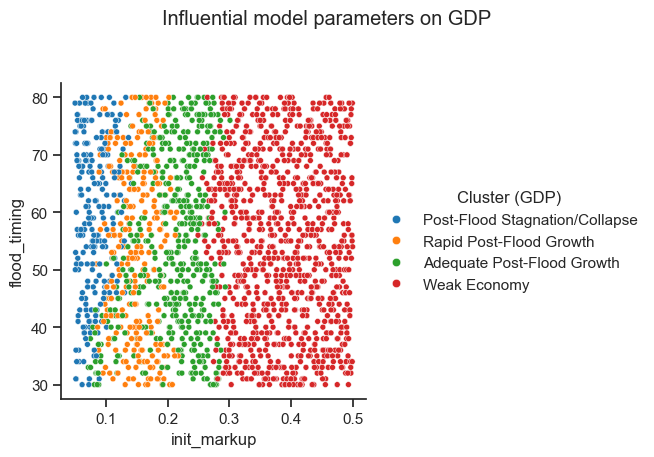

In [72]:
for cluster_var in ['Cluster (GDP)']:
    var_name = ''.join(cluster_var.split('(')[1:])[:-1]

    # sns.pairplot(
    #     experiments,
    #     hue=cluster_var,
    #     vars=restricted_dims[cluster_var],
    #     # vars=independent_vars,
    #     plot_kws=dict(s=25),
    #     diag_kind=None,
    #     # diag_kws=dict(multiple='fill'),
    #     palette='tab10',
    #     corner=True,
    # )
    plt.figure(figsize=(6.7,4))
    ax = sns.scatterplot(
        experiments,
        hue=cluster_var,
        x='init_markup',
        y='capital_firm_cap_out_ratio',
        size=25,
        # vars=restricted_dims[cluster_var],
        # vars=independent_vars,
        # plot_kws=dict(s=25),
        # diag_kind=None,
        # diag_kws=dict(multiple='fill'),
        palette='tab10',
        # corner=True,
    )
    
    # Change label names
    handles, _  = ax.get_legend_handles_labels()
    ax.legend(handles, cluster_names)
    sns.move_legend(
        ax,
        title=cluster_var,
        # handles=handles,
        bbox_to_anchor=(1, 0.5),
        loc='center left',
        ncol=1,
        frameon=False,
    )
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((1,1,1,0))
    # legend.get_frame().set_edgecolor((1,1,1,0))

    plt.tight_layout()

    sns.despine()
    
    save_fig(title=f'{var_name}_ scatter clustered', dir=f'{nfl}rule_induction')
    
    plt.suptitle(f'Influential model parameters on {var_name}', y=1.14)
    plt.show()

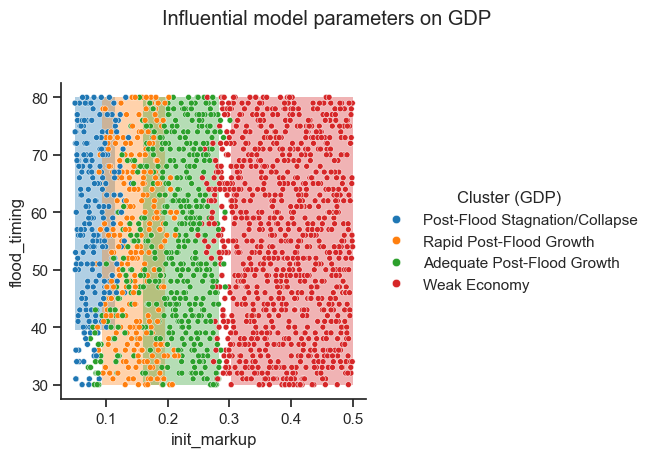

In [74]:
for cluster_var in ['Cluster (GDP)']:
    var_name = ''.join(cluster_var.split('(')[1:])[:-1]
    clusters = np.sort(experiments[cluster_var].unique())
    n_clusters = max(clusters) + 1
    # sns.pairplot(
    #     experiments,
    #     hue=cluster_var,
    #     vars=restricted_dims[cluster_var],
    #     # vars=independent_vars,
    #     plot_kws=dict(s=25),
    #     diag_kind=None,
    #     # diag_kws=dict(multiple='fill'),
    #     palette='tab10',
    #     corner=True,
    # )
    plt.figure(figsize=(6.7,4))
    
    for cluster in clusters:
        prim_box_plot(experiments['init_markup'],
                    experiments['capital_firm_cap_out_ratio'],
                    **{'cluster_var' : cluster_var,
                        'label' : cluster,
                        'color' : cluster_palette[cluster],
                        'alpha' : 0.35})
        
    ax = sns.scatterplot(
        experiments,
        hue=cluster_var,
        x='init_markup',
        y='capital_firm_cap_out_ratio',
        size=25,
        # edgecolor='k',
        # vars=restricted_dims[cluster_var],
        # vars=independent_vars,
        # plot_kws=dict(s=25),
        # diag_kind=None,
        # diag_kws=dict(multiple='fill'),
        palette='tab10',
        # corner=True,
    )
    
    # Change label names
    handles, _  = ax.get_legend_handles_labels()
    ax.legend(handles, cluster_names)
    sns.move_legend(
        ax,
        title=cluster_var,
        # handles=handles,
        bbox_to_anchor=(1, 0.5),
        loc='center left',
        ncol=1,
        frameon=False,
    )
    # legend.get_frame().set_alpha(None)
    # legend.get_frame().set_facecolor((1,1,1,0))
    # legend.get_frame().set_edgecolor((1,1,1,0))

    plt.tight_layout()

    sns.despine()
    
    save_fig(title=f'{var_name}_ scatter clustered with prim boxes', dir=f'{nfl}rule_induction')
    
    plt.suptitle(f'Influential model parameters on {var_name}', y=1.14)
    plt.show()